There are 4 columns in csv file: 

* the filepaths column contains the relative path to the image file
* the labels column contains the text label associated with the image file
* the data set column defines which dataset the image file belongs to (either train or test)
* the class index column defines the integer index of the images class where:
    * class Dark has class index 0
    * class Green has class index 1
    * class Light has class index 2
    * class Medium has class index 3

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('./data/Coffee Bean.csv')

In [3]:
df.shape

(1600, 4)

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,class_index,filepaths,labels,data_set
0,0,train/Dark/dark (1).png,Dark,train
1,0,train/Dark/dark (10).png,Dark,train
2,0,train/Dark/dark (100).png,Dark,train
3,0,train/Dark/dark (101).png,Dark,train
4,0,train/Dark/dark (102).png,Dark,train


In [5]:
df.columns

Index(['class_index', 'filepaths', 'labels', 'data_set'], dtype='object')

In [6]:
df.groupby(by='data_set')['class_index'].count()/df.shape[0]

data_set
test     0.25
train    0.75
Name: class_index, dtype: float64

It is used 25% of data for testing. Let's keep it

## Data preparation and setting validation framework

In [7]:
df_full_train = df[df.data_set == 'train']
del df_full_train['data_set']
df_test = df[df.data_set == 'test']
del df_test['data_set']

We will use 20% of train data for validation

In [8]:
ramdom_state = 42
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=ramdom_state)

In [9]:
df_train.shape, df_val.shape, df_test.shape

((960, 3), (240, 3), (400, 3))

# EDA

In [10]:
df_train.isnull().sum()

class_index    0
filepaths      0
labels         0
dtype: int64

There are no missed values

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 331 to 1126
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_index  960 non-null    int64 
 1   filepaths    960 non-null    object
 2   labels       960 non-null    object
dtypes: int64(1), object(2)
memory usage: 30.0+ KB


Class_index and labels are the same features. So Class_index is a categorical feature

In [12]:
df_labels = df_train.groupby('labels')['filepaths'].count().reset_index()
df_labels.columns = ['labels', 'count']
df_labels

,labels,count
0,Dark,238
1,Green,240
2,Light,240
3,Medium,242


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<AxesSubplot:xlabel='labels', ylabel='count'>

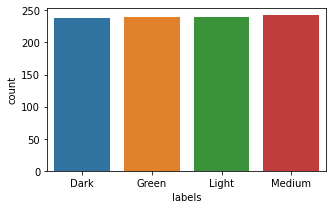

In [14]:
plt.figure(figsize=(5,3))
sns.barplot(x=df_labels['labels'], y=df_labels['count'])


Train data is balansed. Try to find duplicates

In [15]:
from PIL import Image
import imagehash

def calculate_phashes(image_stream):
    img = Image.open(image_stream)
    phash = str(imagehash.phash(img))
    return phash


In [16]:
phashes = []
for path in df_train.filepaths:
    im_path = './data/' + path
    phashes.append(calculate_phashes(im_path))

In [17]:
df_train['phashes'] = phashes

In [18]:
df_train = df_train.reset_index(drop=True)

In [19]:
duplicates = pd.DataFrame(df_train.duplicated(subset=['phashes']) )
duplicates[duplicates[0] == True]

,0
307,True
428,True
696,True
795,True


In [20]:
list_of_indices = list(duplicates[duplicates[0] == True].index)

In [21]:
dupl_hashes_list = list(df_train.iloc[list_of_indices]['phashes'])

In [22]:
dupl_hashes_list

['e3849d1b9a696965',
 'fb94c04a8f6d3866',
 'b2c7c93c2433678d',
 'e96997d6189a6361']

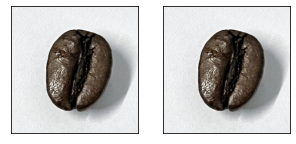

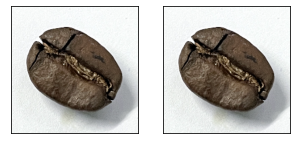

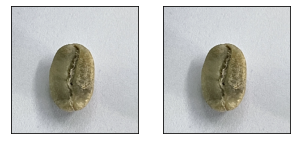

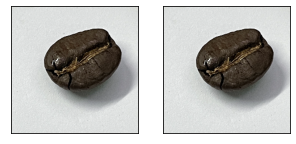

In [23]:
for hash in dupl_hashes_list:
    filepath_list = list(df_train[df_train.phashes == hash]['filepaths'])
    plt.figure(figsize=(5,5))
    for ind, path in enumerate(filepath_list):
        im_path = './data/' + path
        img = Image.open(im_path)
        plt.subplot(1, 2, ind+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)

Indeed, there are some duplicates in the dataset. Let's delete them

In [24]:
df_train = df_train.drop_duplicates(subset=['phashes'], keep='first').reset_index(drop=True)

Check size of images

In [25]:
size = []
for path in df_train.filepaths:
    im_path = './data/' + path
    img = Image.open(im_path)
    size.append(img.size)

set(size)

{(224, 224)}

All pictures have the same size. Let's visualize pictures from different classes

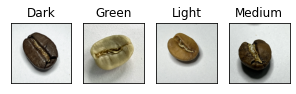

In [26]:
plt.figure(figsize=(5,5))
for ind, cl in enumerate(df_labels['labels']):
    path = df_train[df_train['labels'] == cl].iloc[0]['filepaths']
    im_path = './data/' + path
    img = Image.open(im_path)
    plt.subplot(1, 4, ind+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(cl)
    plt.imshow(img)
    


Let's prepare validation data

In [27]:
def data_preparation(dataset):
    phashes = []
    for path in dataset.filepaths:
        im_path = './data/' + path
        phashes.append(calculate_phashes(im_path))
    dataset['phashes'] = phashes
    dataset = dataset.drop_duplicates(subset=['phashes'], keep='first').reset_index(drop=True)
    return dataset

In [28]:
df_val = data_preparation(df_val)

In [29]:
df_val.shape

(240, 4)

We can see, than there are no duplicates in validation dataset. Visuzlize some data

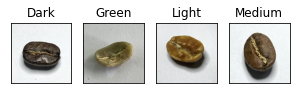

In [30]:
plt.figure(figsize=(5,5))
for ind, cl in enumerate(df_labels['labels']):
    path = df_val[df_val['labels'] == cl].iloc[0]['filepaths']
    im_path = './data/' + path
    img = Image.open(im_path)
    plt.subplot(1, 4, ind+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(cl)
    plt.imshow(img)
    

Let's use the following models:

* convolutional neural network from scratch
* transfer learning (Xception as base model)


In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [32]:
input_shape=(150, 150, 3)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 64)                5

In [34]:
learning_rate = 0.001
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy()

In [35]:
train_gen = ImageDataGenerator(rescale=1./255)

Prepare train and validation data for model fitting

In [36]:
train_ds = train_gen.flow_from_dataframe(
    dataframe=df_train,
    directory="./data/",
    x_col="filepaths",
    y_col="labels",
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(150, 150))

Found 956 validated image filenames belonging to 4 classes.


In [37]:
val_ds = train_gen.flow_from_dataframe(
    dataframe=df_val,
    directory="./data/",
    x_col="filepaths",
    y_col="labels",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(150, 150))

Found 240 validated image filenames belonging to 4 classes.


In [38]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [39]:
checkpoint = keras.callbacks.ModelCheckpoint('model_version_{epoch:03d}_{val_accuracy:.3f}.h5',
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True, 
                                            )

In [40]:
history = model.fit(train_ds, 
                    epochs=10, 
                    validation_data=val_ds,
                    callbacks=[checkpoint]
                )

Epoch 1/10
30/30 [==============================] - 25s 761ms/step - loss: 1.7516 - accuracy: 0.4603 - val_loss: 0.4396 - val_accuracy: 0.9208
Epoch 2/10
30/30 [==============================] - 21s 698ms/step - loss: 0.5321 - accuracy: 0.8086 - val_loss: 0.4714 - val_accuracy: 0.7750
Epoch 3/10
30/30 [==============================] - 21s 698ms/step - loss: 0.4028 - accuracy: 0.8577 - val_loss: 0.2239 - val_accuracy: 0.9542
Epoch 4/10
30/30 [==============================] - 21s 700ms/step - loss: 0.1998 - accuracy: 0.9383 - val_loss: 0.1113 - val_accuracy: 0.9625
Epoch 5/10
30/30 [==============================] - 21s 696ms/step - loss: 0.3643 - accuracy: 0.9226 - val_loss: 0.5030 - val_accuracy: 0.8000
Epoch 6/10
30/30 [==============================] - 21s 692ms/step - loss: 0.1728 - accuracy: 0.9425 - val_loss: 0.0858 - val_accuracy: 0.9833
Epoch 7/10
30/30 [==============================] - 21s 693ms/step - loss: 0.2124 - accuracy: 0.9320 - val_loss: 0.0590 - val_accuracy: 0.9917

The last epoch has the highest accuracy, so let's use fimal model

In [41]:
test_ds = train_gen.flow_from_dataframe(
    dataframe=df_test,
    directory="./data/",
    x_col="filepaths",
    y_col="labels",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(150, 150))

Found 400 validated image filenames belonging to 4 classes.


In [42]:
test_loss, test_acc = model.evaluate(test_ds)

13/13 [==============================] - 4s 287ms/step - loss: 0.0182 - accuracy: 0.9975


In [44]:
model.save_weights('final1.h5')

In [43]:
test_acc

0.9975000023841858

In [46]:
im_path_test = './data/test/Light/light (7).png'
img = load_img(im_path_test, target_size=(150,150))
img = np.array(img, dtype='float')/255 
X = np.array([img])
pred = model.predict(X)

1/1 [==============================] - 0s 203ms/step


In [47]:
labels = list(train_ds.class_indices.keys())
prediction = list(zip(labels, list(pred[0])))
prediction

[('Dark', 2.2270352e-13),
 ('Green', 6.7323876e-05),
 ('Light', 0.9999232),
 ('Medium', 9.466292e-06)]

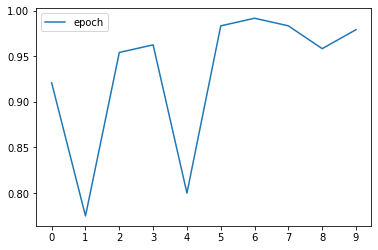

In [48]:
plt.plot(history.history['val_accuracy'], label='epoch')

plt.xticks(np.arange(10))
plt.legend()

In [54]:
model.load_weights('final1.h5')

In [55]:
test_loss, test_acc = model.evaluate(test_ds)

13/13 [==============================] - 4s 277ms/step - loss: 0.0182 - accuracy: 0.9975


The model gives good results. Let's try to tune learning rate parameter

In [51]:
def make_model(learning_rate=0.001, input_shape=(150, 150, 3)):
    # Model ########################################################################
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))

    # Optimizer and loss ###########################################################
    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()

    # Compilation ##################################################################
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

    return model

In [52]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
scores = {}
for lr in learning_rates:
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, 
                    epochs=10, 
                    validation_data=val_ds,
                )
    scores[lr] = history.history


Epoch 1/10
30/30 [==============================] - 23s 734ms/step - loss: 198779.8594 - accuracy: 0.3462 - val_loss: 1.4209 - val_accuracy: 0.4875
Epoch 2/10
30/30 [==============================] - 21s 715ms/step - loss: 1.3231 - accuracy: 0.5387 - val_loss: 0.8996 - val_accuracy: 0.6125
Epoch 3/10
30/30 [==============================] - 20s 673ms/step - loss: 0.8039 - accuracy: 0.6579 - val_loss: 0.8080 - val_accuracy: 0.6333
Epoch 4/10
30/30 [==============================] - 20s 668ms/step - loss: 22.6298 - accuracy: 0.5293 - val_loss: 1.7119 - val_accuracy: 0.2500
Epoch 5/10
30/30 [==============================] - 20s 659ms/step - loss: 1.4287 - accuracy: 0.2573 - val_loss: 1.4000 - val_accuracy: 0.2417
Epoch 6/10
30/30 [==============================] - 20s 667ms/step - loss: 1.4055 - accuracy: 0.2563 - val_loss: 1.3875 - val_accuracy: 0.2500
Epoch 7/10
30/30 [==============================] - 21s 712ms/step - loss: 1.4010 - accuracy: 0.2646 - val_loss: 1.3915 - val_accuracy: 

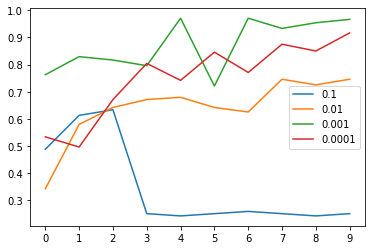

In [53]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=lr)

plt.xticks(np.arange(10))
plt.legend()

According to graphics the best learning rate is 0.001 and we have already evaluated the model

Let's use Xception

In [56]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

In [57]:
base_model = Xception(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))
base_model.trainable = False

In [58]:
inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs)

vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(4, activation='softmax')(vectors)
model_xc = keras.Model(inputs, outputs)

In [59]:
checkpoint = keras.callbacks.ModelCheckpoint('model_xc_version_{epoch:03d}_{val_accuracy:.3f}.h5',
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True, 
                                            )

In [60]:
model_xc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_10 (Dense)            (None, 4)                 8196      
                                                                 
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
_________________________________________________________________


In [61]:
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)

model_xc.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [62]:
train_gen_xc = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds_xc = train_gen_xc.flow_from_dataframe(
    dataframe=df_train,
    directory="./data/",
    x_col="filepaths",
    y_col="labels",
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(150, 150))

val_ds_xc = train_gen_xc.flow_from_dataframe(
    dataframe=df_val,
    directory="./data/",
    x_col="filepaths",
    y_col="labels",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(150, 150))

teat_ds_xc = train_gen_xc.flow_from_dataframe(
    dataframe=df_test,
    directory="./data/",
    x_col="filepaths",
    y_col="labels",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(150, 150))

Found 956 validated image filenames belonging to 4 classes.
Found 240 validated image filenames belonging to 4 classes.
Found 400 validated image filenames belonging to 4 classes.


In [63]:
history_xc = model_xc.fit(train_ds_xc, 
                    epochs=10, 
                    validation_data=val_ds_xc,
                    callbacks=[checkpoint])

Epoch 1/10
30/30 [==============================] - 111s 4s/step - loss: 0.9017 - accuracy: 0.6349 - val_loss: 0.5426 - val_accuracy: 0.8208
Epoch 2/10
30/30 [==============================] - 87s 3s/step - loss: 0.4197 - accuracy: 0.8536 - val_loss: 0.3805 - val_accuracy: 0.8875
Epoch 3/10
30/30 [==============================] - 60s 2s/step - loss: 0.3160 - accuracy: 0.9038 - val_loss: 0.3259 - val_accuracy: 0.8833
Epoch 4/10
30/30 [==============================] - 60s 2s/step - loss: 0.2535 - accuracy: 0.9320 - val_loss: 0.2899 - val_accuracy: 0.9000
Epoch 5/10
30/30 [==============================] - 61s 2s/step - loss: 0.2170 - accuracy: 0.9508 - val_loss: 0.2701 - val_accuracy: 0.9125
Epoch 6/10
30/30 [==============================] - 60s 2s/step - loss: 0.1851 - accuracy: 0.9623 - val_loss: 0.2568 - val_accuracy: 0.9125
Epoch 7/10
30/30 [==============================] - 61s 2s/step - loss: 0.1652 - accuracy: 0.9665 - val_loss: 0.2533 - val_accuracy: 0.9208
Epoch 8/10
30/30 [=

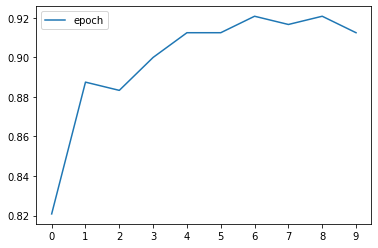

In [64]:
plt.plot(history_xc.history['val_accuracy'], label='epoch')

plt.xticks(np.arange(10))
plt.legend()

In [65]:
model_xc.save_weights('final_xc.h5')

In [67]:
model_xc.load_weights('model_xc_version_007_0.921.h5')

In [68]:
test_loss, test_acc = model_xc.evaluate(test_ds)
test_acc

13/13 [==============================] - 21s 2s/step - loss: 0.2008 - accuracy: 0.9400


0.9399999976158142

In [69]:
pred_xc = model_xc.predict(X)
prediction = list(zip(labels, list(pred[0])))
prediction

1/1 [==============================] - 2s 2s/step


[('Dark', 2.2270352e-13),
 ('Green', 6.7323876e-05),
 ('Light', 0.9999232),
 ('Medium', 9.466292e-06)]

This model gives a little bit worse result, but still good

Let tune learning_rate parameter

In [70]:
def make_model_xc(learning_rate=0.001, input_shape=(150, 150, 3)):
    # Model ########################################################################
    base_model = Xception(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs)

    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(4, activation='softmax')(vectors)
    model = keras.Model(inputs, outputs)


    # Optimizer and loss ###########################################################
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()

    # Compilation ##################################################################
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

    return model

In [74]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
scores_xc = {}
for lr in learning_rates:
    model = make_model_xc(learning_rate=learning_rate)
    history = model.fit(train_ds_xc, 
                    epochs=10, 
                    validation_data=val_ds_xc,
                )
    scores_xc[lr] = history.history


Epoch 1/10
30/30 [==============================] - 64s 2s/step - loss: 0.8758 - accuracy: 0.6433 - val_loss: 0.5465 - val_accuracy: 0.8208
Epoch 2/10
30/30 [==============================] - 62s 2s/step - loss: 0.4223 - accuracy: 0.8567 - val_loss: 0.4171 - val_accuracy: 0.8750
Epoch 3/10
30/30 [==============================] - 62s 2s/step - loss: 0.3139 - accuracy: 0.9059 - val_loss: 0.3363 - val_accuracy: 0.8833
Epoch 4/10
30/30 [==============================] - 60s 2s/step - loss: 0.2574 - accuracy: 0.9331 - val_loss: 0.3046 - val_accuracy: 0.8875
Epoch 5/10
30/30 [==============================] - 60s 2s/step - loss: 0.2138 - accuracy: 0.9414 - val_loss: 0.2906 - val_accuracy: 0.9000
Epoch 6/10
30/30 [==============================] - 60s 2s/step - loss: 0.1856 - accuracy: 0.9582 - val_loss: 0.2682 - val_accuracy: 0.9125
Epoch 7/10
30/30 [==============================] - 60s 2s/step - loss: 0.1666 - accuracy: 0.9592 - val_loss: 0.2574 - val_accuracy: 0.9125
Epoch 8/10
30/30 [==

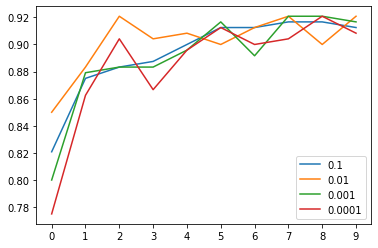

In [75]:
for lr, hist in scores_xc.items():
    plt.plot(hist['val_accuracy'], label=lr)

plt.xticks(np.arange(10))
plt.legend()

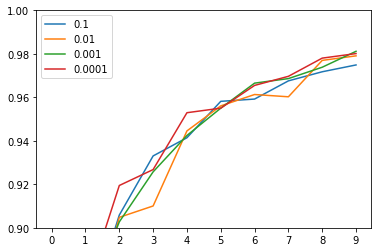

In [77]:
for lr, hist in scores_xc.items():
    plt.plot(hist['accuracy'], label=lr)

plt.xticks(np.arange(10))
plt.ylim([0.9, 1])
plt.legend()

As we can see that, when learning rate equals 0.001 the model has good performance. Let's keep it.

# Conclusions

* The model from scratch has better performance, then model built on Xception
* The best learning rate parameter is 0.001


That is why we will keep the first model

Further investigation:

* Add dropout layers
* Concider different optimizers
* Change architecture of neural network

After all this work was done, it was noticed that test data contains a lot of train, so let's delete duplicates and test model on unseen data

In [83]:
phashes = []
for path in df.filepaths:
    im_path = './data/' + path
    phashes.append(calculate_phashes(im_path))

In [80]:
df_dupl = df.copy()
df_dupl['phashes'] = phashes
duplicates_all = pd.DataFrame(df_dupl.duplicated(subset=['phashes']) )
len(duplicates_all[duplicates_all[0] == True])

406

In [81]:
df_dupl = df_dupl.drop_duplicates(subset=['phashes'], keep='first')
df_test_without_dupl = df_dupl[df_dupl.data_set == 'test']
len(df_test_without_dupl)

0

Oops, all test data is taken from train data. Unfortunately.
For the final model let's train model with additional 10 epochs on data received after augmentation

In [85]:
final_model = make_model()
final_model.load_weights('model_version_007_0.992.h5')

In [86]:
train_gen_augm = ImageDataGenerator(rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

In [87]:
train_ds_augm = train_gen_augm.flow_from_dataframe(
    dataframe=df_train,
    directory="./data/",
    x_col="filepaths",
    y_col="labels",
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(150, 150))

Found 956 validated image filenames belonging to 4 classes.


In [88]:
checkpoint = keras.callbacks.ModelCheckpoint('final_model_v_{epoch:03d}_{val_accuracy:.3f}.h5',
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True, 
                                            )

In [89]:
final_history = final_model.fit(train_ds_augm, 
                    epochs=10, 
                    validation_data=val_ds,
                    callbacks=[checkpoint]
                )

Epoch 1/10
30/30 [==============================] - 31s 990ms/step - loss: 0.3905 - accuracy: 0.8828 - val_loss: 0.1777 - val_accuracy: 0.9250
Epoch 2/10
30/30 [==============================] - 26s 854ms/step - loss: 0.2570 - accuracy: 0.9153 - val_loss: 0.2734 - val_accuracy: 0.9042
Epoch 3/10
30/30 [==============================] - 25s 835ms/step - loss: 0.2055 - accuracy: 0.9331 - val_loss: 0.0622 - val_accuracy: 0.9792
Epoch 4/10
30/30 [==============================] - 26s 864ms/step - loss: 0.2414 - accuracy: 0.9100 - val_loss: 0.0685 - val_accuracy: 0.9792
Epoch 5/10
30/30 [==============================] - 26s 850ms/step - loss: 0.1590 - accuracy: 0.9477 - val_loss: 0.5848 - val_accuracy: 0.8125
Epoch 6/10
30/30 [==============================] - 26s 845ms/step - loss: 0.1861 - accuracy: 0.9341 - val_loss: 0.0734 - val_accuracy: 0.9750
Epoch 7/10
30/30 [==============================] - 26s 843ms/step - loss: 0.1612 - accuracy: 0.9383 - val_loss: 0.1038 - val_accuracy: 0.9583

In [90]:
final_model.load_weights('final_model_v_008_0.988.h5')

In [91]:
test_loss, test_acc = final_model.evaluate(test_ds)
test_acc

13/13 [==============================] - 4s 286ms/step - loss: 0.0634 - accuracy: 0.9800


0.9800000190734863

In [110]:
final_model.save('final_model.h5')
print('model saved')

model saved
